##### Copyright 2024 Google LLC.

In [38]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [40]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [41]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c966faf1-e63c-4b36-a67e-c93d77948caf-0', usage_metadata={'input_tokens': 3, 'output_tokens': 4, 'total_tokens': 7, 'input_token_details': {'cache_read': 0}})

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

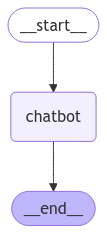

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [35]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi
Assistant: Hi there! How can I help you today?

User: What do you know about LangGraph?
Assistant: LangGraph isn't a widely known or established, single, defined technology or project like, say, TensorFlow or Neo4j.  There's no single, definitive "LangGraph" out there.  The name likely refers to a concept or a project specific to a certain research group, company, or individual.

However, based on the name, it's highly probable that LangGraph refers to a system or approach that combines **natural language processing (NLP)** with **graph databases** or **graph-based representations**.

Here's what such a system might entail:

* **NLP Component:** This part would handle tasks like text processing, tokenization, part-of-speech tagging, named entity recognition, sentiment analysis, and potentially more sophisticated NLP techniques like relation extraction or semantic role labeling.

* **Graph Component:** This would involve representing the information extracted from the text as a